In [1]:
import pandas as pd
import quandl as qd
import math
import numpy as np
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import pickle
style.use('ggplot')

In [2]:
df = qd.get('WIKI/GOOGL', authtoken='XcsQAGKmgBo41qE1xmDe')
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [3]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

In [4]:
#percentage change in high - low
df['hl_pct'] = df['Adj. High'] - df['Adj. Low'] / df['Adj. Low'] * 100

In [5]:
#percentage per day
df['pct_change'] = df['Adj. Close'] - df['Adj. Open'] / df['Adj. Open'] * 100

In [6]:
df = df[['Adj. Close', 'hl_pct', 'pct_change', 'Adj. Volume']]
df.head()

,Adj. Close,hl_pct,pct_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,-47.808891,-49.677158,44659000.0
2004-08-20,54.322689,-45.291119,-45.677311,22834300.0
2004-08-23,54.869377,-43.084307,-45.130623,18256100.0
2004-08-24,52.597363,-44.027217,-47.402637,15247300.0
2004-08-25,53.164113,-45.832791,-46.835887,9188600.0


In [7]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace = True)

In [8]:
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)
df.head()
print(forecast_out)

35


In [9]:
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X = X[:-forecast_out]
X_lately = X[-forecast_out:]

In [10]:
df.dropna(inplace = True)
y = np.array(df['label'])
print(len(X), len(y))

3389 3389


In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)
#clf = LinearRegression(n_jobs = -1)
#clf.fit(X_train, y_train)trained data
#saving the 
#with open('linearregression.pickle', 'wb') as f:
#    pickle.dump(clf, f)
pickle_in = open('linearregression', 'rb')
clf = pickle.load(pickle_in)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.9783650551718004


In [12]:
clf_svm = svm.SVR()
clf_svm.fit(X_train, y_train)
accuracy_s = clf_svm.score(X_test, y_test)
print(accuracy_s)

C:\Users\HACADEMY\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8669237117183505


In [13]:
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

[1074.56036667 1089.0790848  1103.23015691 1097.58927307 1091.00326621
 1088.48741798 1087.05290965 1083.9819583  1077.71548647 1073.37599599
 1071.16446638 1091.09736062 1109.33699385 1113.34399463 1128.38695247
 1132.32881942 1130.73513595 1128.53274897 1130.21264407 1148.94155812
 1147.23621912 1157.76566587 1154.16879106 1162.1549244  1182.68170038
 1194.61248585 1188.31545642 1200.77927027 1206.24340877 1204.18099399
 1194.9860897  1200.61044531 1199.23684168 1134.31831954 1081.03077457] 0.9783650551718004 35


In [14]:
df['forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [15]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]
df.head()

,Adj. Close,hl_pct,pct_change,Adj. Volume,label,forecast
Date,,,,,,
2004-08-19,50.322842,-47.808891,-49.677158,44659000.0,69.078238,NaN
2004-08-20,54.322689,-45.291119,-45.677311,22834300.0,67.839414,NaN
2004-08-23,54.869377,-43.084307,-45.130623,18256100.0,68.912727,NaN
2004-08-24,52.597363,-44.027217,-47.402637,15247300.0,70.668146,NaN
2004-08-25,53.164113,-45.832791,-46.835887,9188600.0,71.219849,NaN


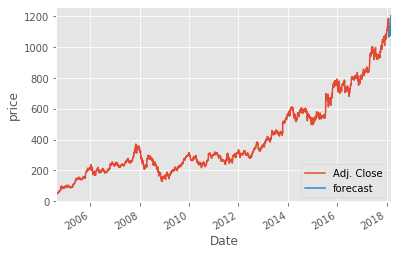

In [16]:
df['Adj. Close'].plot()
df['forecast'].plot()
plt.legend(loc = 4)
plt.xlabel('Date')
plt.ylabel('price')
plt.show()